### Titanic Dataset
* Where does data come from? - https://www.kaggle.com/c/titanic/data
* What is our target? - We want to predict whether or not a person survive.
* What kind of problem is that? - Classification problem 

#### Importing Necessary Tools

In [96]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use("fivethirtyeight")
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

#### Get Data Ready

In [97]:
train_df = pd.read_csv("data/titanic/train.csv")
test_df = pd.read_csv("data/titanic/test.csv")

In [98]:
# Check data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [99]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [100]:
# Drop columns which are not useful
to_drop = ["PassengerId", "Name", "Ticket"]
train_df.drop(to_drop, axis = 1, inplace = True)
test_df.drop(to_drop, axis = 1, inplace = True)

In [101]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [102]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q
3,3,male,27.0,0,0,8.6625,NaN,S
4,3,female,22.0,1,1,12.2875,NaN,S


**Feature Engineering**

In [103]:
max(train_df["Age"]), min(train_df["Age"])

(80.0, 0.42)

In [104]:
# As you can see, we have to remove outliers
features_train_df = train_df.drop("Survived", axis = 1)
numeric_train_df = features_train_df.select_dtypes(include = "number")
numeric_train_df.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


In [105]:
numeric_test_df = test_df.select_dtypes(include = "number")
numeric_test_df.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,34.5,0,0,7.8292
1,3,47.0,1,0,7.0000
2,2,62.0,0,0,9.6875
3,3,27.0,0,0,8.6625
4,3,22.0,1,1,12.2875


In [106]:
quantile_age = numeric_train_df["Age"].quantile(0.95)
quantile_fare = numeric_train_df["Fare"].quantile(0.95)
trimmed_df = numeric_train_df[(numeric_train_df["Age"] < quantile_age) & (numeric_train_df["Fare"] < quantile_fare)]

In [107]:
train_df["Age"] = trimmed_df["Age"]
train_df["Fare"] = trimmed_df["Fare"]

In [108]:
quantile_age = numeric_test_df["Age"].quantile(0.95)
quantile_fare = numeric_test_df["Fare"].quantile(0.95)
trimmed_df = numeric_test_df[(numeric_test_df["Age"] < quantile_age) & (numeric_test_df["Fare"] < quantile_fare)]

In [109]:
test_df["Age"] = trimmed_df["Age"]
test_df["Fare"] = trimmed_df["Fare"]

In [110]:
max(train_df["Age"]), min(train_df["Age"]), max(train_df["Fare"]), min(train_df["Fare"])

(55.5, 0.42, 110.8833, 0.0)

In [111]:
# Discretization age column
train_df["binned_age"] = pd.cut(train_df["Age"], bins = [0, 14, 28, 42, 56], labels = ["Kid", "Teenager", "Adult", "Old"])

In [112]:
train_df[["Age", "binned_age"]].sample(10)

,Age,binned_age
777,5.00,Kid
141,22.00,Teenager
658,23.00,Teenager
78,0.83,Kid
542,11.00,Kid
656,NaN,NaN
363,35.00,Adult
754,48.00,Old
759,33.00,Adult
826,NaN,NaN


In [113]:
test_df["binned_age"] = pd.cut(test_df["Age"], bins = [0, 14, 28, 42, 56], labels = ["Kid", "Teenager", "Adult", "Old"])

In [114]:
test_df[["Age", "binned_age"]].sample(5)

,Age,binned_age
240,55.0,Old
136,26.5,Teenager
85,NaN,NaN
2,NaN,NaN
172,23.0,Teenager


**EDA**

In [115]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,binned_age
0,0,3,male,22.0,1,0,7.2500,NaN,S,Teenager
1,1,1,female,38.0,1,0,71.2833,C85,C,Adult
2,1,3,female,26.0,0,0,7.9250,NaN,S,Teenager
3,1,1,female,35.0,1,0,53.1000,C123,S,Adult
4,0,3,male,35.0,0,0,8.0500,NaN,S,Adult


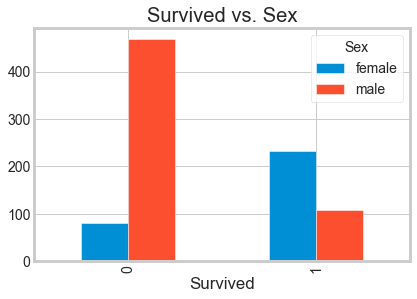

In [116]:
ax = pd.crosstab(train_df["Survived"], train_df["Sex"]).plot(kind = "bar")
ax.set_title("Survived vs. Sex")
plt.show();

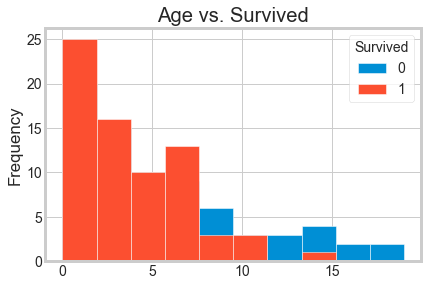

In [117]:
ax = pd.crosstab(train_df["Age"], train_df["Survived"]).plot(kind = "hist")
ax.set_title("Age vs. Survived")
plt.show();

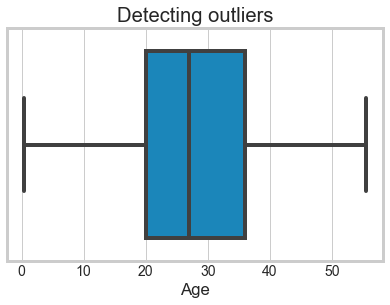

In [118]:
ax = sns.boxplot(x = "Age", data = train_df)
ax.set_title("Detecting outliers")
plt.show();

**As you can see, we did some operations about removing outliers, it seems work!**

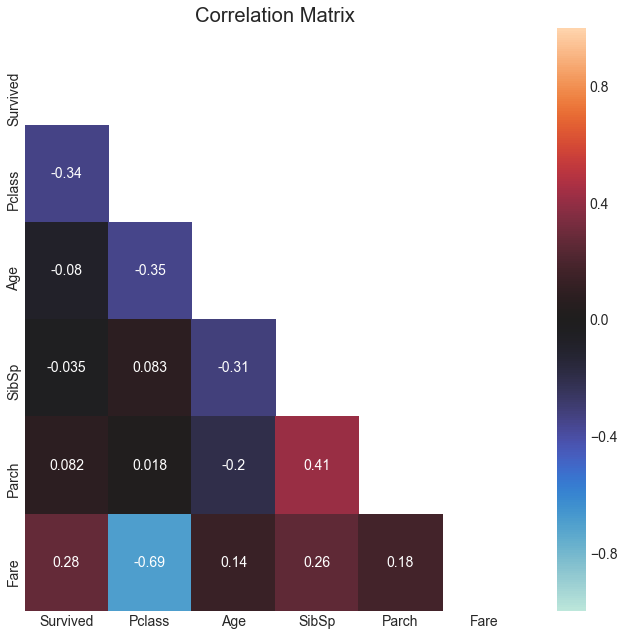

In [119]:
# Correlation matrix
plt.figure(figsize = (10, 10))
corr_matrix = train_df.corr()
matrix = np.triu(corr_matrix)
ax = sns.heatmap(corr_matrix,
                 annot = True,
                 vmin = -1,
                 vmax = 1,
                 center = 0,
                 mask = matrix)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title("Correlation Matrix")
plt.show();

**Baseline Model**
* We are gonna be using Pipeline strategy.
* Steps:
    1. Fill missing data
    2. Convert categorical data to numbers
    3. Build a model on the data

In [120]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Sex           891 non-null object
Age           638 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          638 non-null float64
Cabin         204 non-null object
Embarked      889 non-null object
binned_age    638 non-null category
dtypes: category(1), float64(2), int64(4), object(3)
memory usage: 63.8+ KB


In [121]:
train_df.dropna(subset = ["Survived"], inplace = True)

In [122]:
features_train = train_df.drop("Survived", axis = 1)
categorical_features = features_train.select_dtypes(include = ["object", "category"]).columns.tolist()
numerical_features = features_train.select_dtypes(include = "number").columns.tolist()

In [123]:
categorical_transformer = Pipeline(steps = [
                          ("imputer", SimpleImputer(strategy = "constant", fill_value = "missing")),
                          ("onehot", OneHotEncoder(handle_unknown = "ignore"))
])

In [124]:
numerical_transformer = Pipeline(steps = [
                        ("imputer", SimpleImputer(strategy = "median"))
])

In [125]:
preprocessor = ColumnTransformer(transformers = [
               ("cat", categorical_transformer, categorical_features),
               ("num", numerical_transformer, numerical_features)
])

In [126]:
base_model = Pipeline(steps = [
             ("preprocessor", preprocessor),
             ("classifier", RandomForestClassifier())
])

In [127]:
# Split data into X & y
X = train_df.drop("Survived", axis = 1)
y = train_df["Survived"]

In [128]:
# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [129]:
# Fit the model on the data
base_model.fit(X_train, y_train)

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                      

**Checking overfitting - underfitting using `accuracy_score()`**

In [132]:
# Make predictions on the train & test sets
y_train_preds = base_model.predict(X_train)
y_test_preds = base_model.predict(X_test)

In [133]:
# Import `accuracy_score()` classification metric
from sklearn.metrics import accuracy_score

In [134]:
train_accuracy = accuracy_score(y_train, y_train_preds)
test_accuracy = accuracy_score(y_test, y_test_preds)

In [136]:
print(f"Train accuracy of our model: {train_accuracy}\nTest accuracy of our model: {test_accuracy}")

Train accuracy of our model: 0.9508426966292135
Test accuracy of our model: 0.8268156424581006


**As you can see, our train accuracy >> test accuracy, so, our model underfits!**

**We are gonna do some experiments and try other techniques**

In [141]:
# Import TruncatedSVD
from sklearn.decomposition import TruncatedSVD

In [142]:
pipe = Pipeline(steps = [
       ("preprocessor", preprocessor),
       ("scaler", StandardScaler(with_mean = False)),
       ("reduce_dim", TruncatedSVD()),
       ("classifier", RandomForestClassifier())
])

In [143]:
# Fit the new pipe on the data
pipe.fit(X_train, y_train)

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                      

In [144]:
# Make predictions on the train & test sets
y_train_preds = pipe.predict(X_train)
y_test_preds = pipe.predict(X_test)

In [145]:
train_accuracy = accuracy_score(y_train, y_train_preds)
test_accuracy = accuracy_score(y_test, y_test_preds)

In [146]:
print(f"Train accuracy of our model: {train_accuracy}\nTest accuracy of our model: {test_accuracy}")

Train accuracy of our model: 0.9367977528089888
Test accuracy of our model: 0.7262569832402235


**Trying Other Estimators**

In [147]:
models = {"Random Forest" : RandomForestClassifier(),
          "Decision Tree" : DecisionTreeClassifier(),
          "Logistic Regression" : LogisticRegression(),
          "XGB Classifier" : XGBClassifier(),
          "XGBRF Classifier" : XGBRFClassifier()}

In [148]:
# Create a function to fit and score the given estimators
def fit_and_score(models = models, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    """
    Fits and scores the given estimators and returns scores dictionary which keeps name and score of the model.
    """
    # Create empty scores dictionary
    scores = {}
    # Loop through models
    for name, model in models.items():
        # Create pipe object
        pipe = Pipeline(steps = [
               ("preprocessor", preprocessor),
               ("classifier", model)
        ])
        # Fit the pipe on the data
        pipe.fit(X_train, y_train)
        # Score the pipe and add this score to the scores dictionary
        scores[name] = pipe.score(X_test, y_test)
    # Return scores dictionary
    return scores

In [149]:
scores = fit_and_score()
scores

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'Random Forest': 0.8212290502793296,
 'Decision Tree': 0.7653631284916201,
 'Logistic Regression': 0.7932960893854749,
 'XGB Classifier': 0.8044692737430168,
 'XGBRF Classifier': 0.8044692737430168}

In [151]:
# Import VotingClassifier
from sklearn.ensemble import VotingClassifier

classifiers = [("logreg", LogisticRegression()),
               ("rf", RandomForestClassifier()),
               ("xgb", XGBClassifier())]

vc_pipe = Pipeline(steps = [
          ("preprocessor", preprocessor),
          ("classifier", VotingClassifier(estimators = classifiers))
])

vc_pipe.fit(X_train, y_train)
y_pred = vc_pipe.predict(X_test)
print(f"Accuracy score of VotingClassifier: {accuracy_score(y_test, y_pred)}")

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy score of VotingClassifier: 0.7988826815642458


**Let's continue with `RandomForestClassifier()` and do hyperparameter tuning!**

In [153]:
pipe = Pipeline(steps = [
       ("preprocessor", preprocessor),
       ("classifier", RandomForestClassifier())
])

In [152]:
pipe_grid = {"preprocessor__num__imputer__strategy" : ["mean", "median"],
             "classifier__n_estimators" : np.arange(100, 500, 50),
             "classifier__max_depth" : [2, 3, 4, 5]}

In [154]:
search = GridSearchCV(estimator = pipe,
                      param_grid = pipe_grid,
                      cv = 5,
                      verbose = 2,
                      n_jobs = -1)

In [155]:
# Fit the search on the data
search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   51.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [156]:
search.best_score_

0.8300561797752809